# Prepoznavanje oblika

Autor: Djordje Marjanovic 2016/0120

## Zadatak 1

Za bazu rukom pisanih samoglasnika, koja je dostupna na sajtu predmeta*
isprojektovati inovativni sistem za prepoznavanje cifara zasnovan na
testiranju hipoteza. Rezultate prikazati u obliku matrice konfuzije. Izveštaj
treba da sadrži kratki opis isprojektovanog sistema, obrazložen izbor
obeležja, kao i karakteristične primere pravilno i nepravilno klasifikovanih
slova.

### Postavka

In [1]:
%reset -f

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# DO NOT MODIFY
dataset_dir = "data/Slova/"
dataset_size_per_letter = 120

labels = ['A', 'E', 'I', 'O', 'U']
train_set_size_per_letter = 80
val_set_size_per_letter = 20
test_set_size_per_letter = 20

### Učitavanje podataka

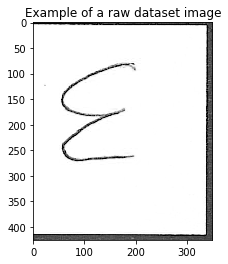

In [2]:
def load_sample(label, idx):
    return cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, label, idx))

def load_set(indices):
    ret_set = []
    for label in labels:
        for idx in indices:
            ret_set.append((label, load_sample(label, idx)))
    return ret_set

def example_set(size):
    return [
        (label, load_sample(label, idx))
        for label, idx in [(
            random.choice(labels),
            random.randint(
                    1, dataset_size_per_letter - test_set_size_per_letter
                )
        ) for i in range(size)]
    ]
            
def load_train_val_test_sets(train_size, val_size):
    indices = list(range(1, train_size + val_size + 1))
    random.shuffle(indices)
    
    train = load_set(indices[:train_size])
    val = load_set(indices[train_size:])
    
    first_test_index = dataset_size_per_letter - test_set_size_per_letter + 1
    test = load_set(range(first_test_index, dataset_size_per_letter + 1))
    
    return train, val, test

sample_example = load_sample(
        random.choice(labels), 
        random.randint(1, 120 - test_set_size_per_letter)
    )

plt.imshow(sample_example)
plt.title("Example of a raw dataset image")
plt.show()

# train_set, val_set, test_set = load_train_val_test_sets(80, 20, 20)
# 
# random_point_index = random.randint(0, len(train_set))
# print(random_point_index)
# 
# random_point = train_set[random_point_index]
# plt.imshow(random_point[1])
# plt.title("Example of a raw dataset image")
# plt.show()

### Odsecanje ivica

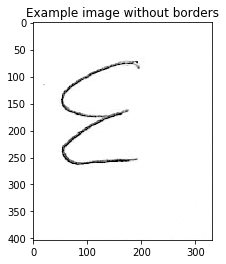

In [3]:
def crop_border(image, border=3):
    img = image[:, :, 0]
    
    search_area = int(0.1 * img.shape[0])
    edge = np.mean(1-img, axis=1) > 50
    if np.sum(edge[search_area::-1]) == 0:
        top = 0
    else:
        top = search_area - np.argmax(edge[search_area::-1])
    if np.sum(edge[-search_area:]) == 0:
        bottom = img.shape[0] - 1
    else:
        bottom = img.shape[0] - search_area + np.argmax(edge[-search_area:])
        
    search_area = int(0.1 * img.shape[1])
    edge = np.mean(1-img, axis=0) > 50
    if np.sum(edge[search_area::-1]) == 0:
        left = 0
    else:
        left = search_area - np.argmax(edge[search_area::-1])
    if np.sum(edge[-search_area:]) == 0:
        right = img.shape[1] - 1
    else:
        right = img.shape[1] - search_area + np.argmax(edge[-search_area:])

    return img[
           top + border: bottom - border,
           left + border: right - border
        ] / 256.0

sample_example = crop_border(sample_example)

plt.imshow(sample_example, cmap='gray')
plt.title("Example image without borders")
plt.show()

# random_point = train_set[13]
# plt.imshow(random_point[1], cmap='gray')
# # plt.show()
# I = crop_border(random_point[1], border=5)
# # plt.imshow(crop_border(random_point[1][0]), cmap='gray')
# plt.xlim(-10, random_point[1].shape[1] + 10)
# plt.ylim(random_point[1].shape[0] + 10, -10)
# plt.show()
# 
# plt.imshow(I < 0.9)
# plt.xlim(-10, I.shape[1] + 10)
# plt.ylim(I.shape[0] + 10, -10)
# plt.show()

In [4]:
# border_size = 30
# train_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in train_set]
# 
# val_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in val_set]
# 
# test_set = [(
#     label,
#     crop_border(sample)
# ) for label, sample in test_set]
# 
# random_point = train_set[random_point_index]
# plt.imshow(random_point[1], cmap = 'gray')
# plt.title("Removed borders")
# plt.show()

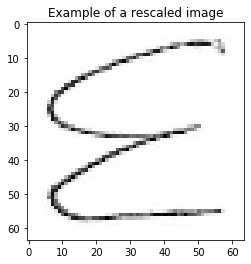

In [5]:
# TODO: split to crop_letter and rescale image 
def crop_letter(image: np.ndarray):
    from scipy.ndimage.morphology import binary_erosion, binary_dilation
    binary_threshold = 0.9
    erosion_size = 5
    padding = 4
    final_size = (64, 64)
    
    binary_image = 1.0 * image < binary_threshold
    binary_image = binary_erosion(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    binary_image = binary_dilation(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    
    x, y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
    x = x * binary_image
    y = y * binary_image
    
    u_bound = max(0, np.min(y[np.nonzero(y)]) - erosion_size)
    b_bound = min(image.shape[0] - 1, y.max() + erosion_size + 1)
    l_bound = max(0, np.min(x[np.nonzero(x)]) - erosion_size)
    r_bound = min(image.shape[1] - 1, x.max() + erosion_size + 1)
    
    cropped_image = image[u_bound: b_bound, l_bound: r_bound]
    resized_image = cv2.resize(
        src = cropped_image,
        dsize = (final_size[1] - 2 * padding, final_size[0] - 2 * padding)
    )
    
    final_image = np.ones(final_size)
    final_image[
        padding: final_size[0] - padding,
        padding: final_size[1] - padding
    ] = resized_image
    
    return 1 - final_image

sample_example = crop_letter(sample_example)

plt.imshow(1 - sample_example, cmap='gray')
plt.title("Example of a rescaled image")
plt.show()

# plt.imshow(train_set[38 * 9 + 6][1])
# plt.show()
# plt.imshow(crop(train_set[38 * 9 + 6][1]))
# plt.show()

# train_set = [(label, crop_letter(sample)) for label, sample in train_set]
# val_set = [(label, crop_letter(sample)) for label, sample in val_set]
# test_set = [(label, crop_letter(sample)) for label, sample in test_set]
# 
# random_point = train_set[random_point_index]
# fig, ax = plt.subplots(figsize=(15, 15))
# plt.imshow(random_point[1], cmap = 'gray')
# plt.title("Cropped image")
# plt.show()

### Celokupna obrada slike

In [6]:
def process_image(img: np.ndarray):
    return crop_letter(crop_border(img))

### Odsecanje nad podacima

In [7]:
def preprocess_set(raw_set: list):
    return [
        (label, process_image(image))
        for label, image in raw_set
    ]

### Funkcija za vizuelizaciju

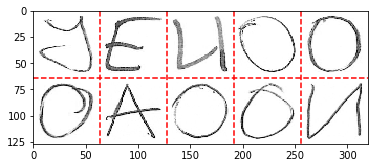

In [8]:
def display_square(imgs: list, n: int, m: int):
    w, h = imgs[0].shape
    comb = np.zeros((h * n, w * m))
    for i in range(n):
        for j in range(m):
            comb[i * h: (i + 1) * h, j * w: (j + 1) * w] = imgs[i * m + j]
    plt.imshow(comb, cmap = 'gray')
    for i in range(1, n):
        plt.plot([0, m * w], [i * h, i * h], '--r')
    for j in range(1, m):
        plt.plot([j * w, j * w], [0, n * h - 1], '--r')
    plt.xlim(0, w * m)
    plt.ylim(h * n - 1, 0)

display_square([
        1 - process_image(sample[1])
        for sample in example_set(10)],
        2, 5
    )
plt.show()

In [9]:
# @interact(image_id = (0, len(train_set) // 9))
# def example(image_id=0):
#     fig, ax = plt.subplots(figsize=(10, 10))
#     start = image_id * 9
#     end = start + 9
#     display_square([img for label, img in train_set[start: end]], 3, 3)
#     plt.show()

### Vestacko povecanje baze

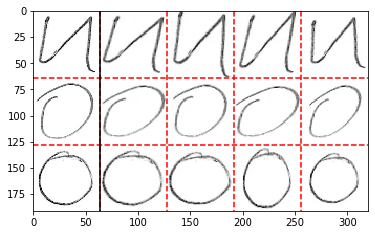

In [10]:
def generate_augmented_image(image: np.ndarray, variance: float = 0.3):
    translate_to_center = np.eye(3)
    translate_to_center[:2, 2] = -np.array(image.shape).T / 2

    translate_from_center = np.eye(3)
    translate_from_center[:2, 2] = np.array(image.shape).T / 2

    affine = np.zeros((3, 3))
    affine[:2, :2] = np.eye(2) + (np.random.rand(2, 2) - 0.5) * variance
    affine[2, :] = np.array([0, 0, 1])
    affine[:2, 2] = (np.random.rand(2) - 0.5) * variance

    final = translate_from_center.dot(affine.dot(translate_to_center)) 
    
    return cv2.warpPerspective(image, final, image.shape, borderValue=0)

display_square(sum([
            [1 - img] + [1 - generate_augmented_image(img) for j in range(4)]
            for img in [process_image(sample[1]) for sample in example_set(3)]
        ], []),
        3, 5
    )
plt.plot([64, 64], [0, 64 * 3], '-k')
plt.show()

### Karakteristike

In [11]:
import features

def create_feature_vector(features: list, raw_set: list):
    return np.array([
        [labels.index(label)] + [
            feature.get_feature(sample) for feature in features
        ]
        for label, sample in raw_set
    ])

# TODO: features.IntegralImage()
example_features = [
    features.Stack([
        features.RectSelect(20, 43, 20, 43),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(0, 63, 0, 63),
        features.Mean()
    ])
]

example_feature_vector = create_feature_vector(
        example_features, [
            (label, process_image(img)) for label, img in example_set(100)
        ]
    ) 

# X = np.array([
#     [letters.index(letter)] + [
#         feature.get_feature(sample)
#         for feature in selected_features
#     ]
#     for letter, sample in train_set
# ])
# 
# X_test = np.array([
#     [letters.index(letter)] + [
#         feature.get_feature(sample)
#         for feature in selected_features
#     ]
#     for letter, sample in val_set
# ])
# 
# print(selected_features[0].get_feature(random_point[1]))

### Vizuelizacija karakteristika

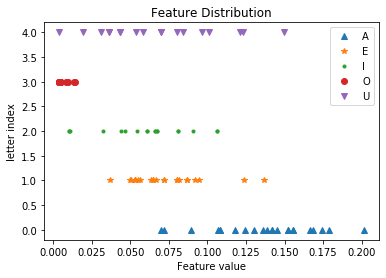

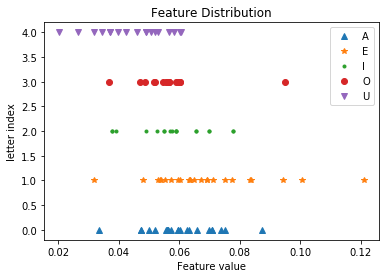

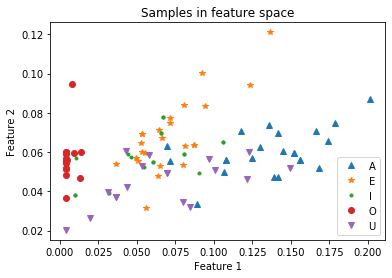

In [12]:
letter_to_symbol = {
    'A': '^',
    'E': '*',
    'I': '.',
    'O': 'o',
    'U': 'v',
}


def feature_distribution(X: np.ndarray, feature_id: int):
    for label_id in range(len(labels)):
        values = X[X[:, 0] == label_id][:, feature_id + 1]
        plt.plot(
            values,
            np.ones(values.shape[0]) * label_id,
            letter_to_symbol[labels[label_id]]
        )
    plt.legend(labels)
    plt.title('Feature Distribution')
    plt.xlabel('Feature value')
    plt.ylabel('letter index')
    plt.show()


def compare_features(X: np.ndarray, feature1_id: int = 0, feature2_id: int = 1):
    for label_id in range(len(labels)):
        feature_for_label_id = X[X[:, 0] == label_id] 
        plt.plot(
            feature_for_label_id[:, feature1_id + 1],
            feature_for_label_id[:, feature2_id + 1],
            letter_to_symbol[labels[label_id]]
        )
    plt.legend(labels)
    plt.title("Samples in feature space")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

feature_distribution(example_feature_vector, 0)
feature_distribution(example_feature_vector, 1)
compare_features(example_feature_vector)

# feature_distribution(4)
# compare_features(3, 4)
    

### Estimator distribucija

In [13]:
def estimate_normal(X: np.ndarray):
    M = np.array([
        np.mean(X[X[:, 0] == letter_id], axis=0)
        for letter_id in range(len(labels))
    ])[:, 1:]
    
    S = np.array([
        np.cov(X[X[:, 0] == letter_id][:, 1:].T)
        for letter_id in range(len(labels))
    ])
    return M, S

example_M, example_S = estimate_normal(example_feature_vector)
print("M =", example_M)
print("S =", example_S)

M = [[0.13624149 0.06027565]
 [0.07193277 0.0683174 ]
 [0.05883587 0.05801673]
 [0.00575631 0.05680166]
 [0.06785252 0.04470948]]
S = [[[1.12209590e-03 1.88445738e-04]
  [1.88445738e-04 1.28204615e-04]]

 [[5.57792254e-04 3.38517598e-04]
  [3.38517598e-04 3.49240915e-04]]

 [[8.74221729e-04 2.04438279e-04]
  [2.04438279e-04 1.45560026e-04]]

 [[1.11216295e-05 7.34699696e-06]
  [7.34699696e-06 1.32413174e-04]]

 [[1.54092424e-03 2.52786952e-04]
  [2.52786952e-04 1.39696688e-04]]]


### Testiranje hipoteza

In [14]:
def bayesian_inference(M, S, X_test):
    q = [
        scipy.stats.multivariate_normal(
                mean=M[letter_id],
                cov=S[letter_id]
            ).pdf(
                X_test[:, 1:]
            )
        for letter_id in range(len(labels))
    ]
    
    q = np.array(q)
    
    pred = np.argmax(q, axis=0)
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for i in range(X_test.shape[0]):
        confusion_matrix[int(X_test[i, 0]), pred[i]] += 1
    
    accuracy = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
    return accuracy, confusion_matrix

example_accuracy, example_confusion_matrix = \
    bayesian_inference(example_M, example_S, example_feature_vector)
        
print(end='\t')
for letter in labels:
    print(letter, end='\t')
print()    
for i, letter in enumerate(labels):
    print(letter, end='\t')
    for j in range(len(labels)):
        print(example_confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =", example_accuracy)

	A	E	I	O	U	
A	20.0	1.0	1.0	0.0	1.0	
E	0.0	11.0	10.0	0.0	3.0	
I	2.0	4.0	7.0	3.0	2.0	
O	0.0	0.0	1.0	16.0	0.0	
U	3.0	0.0	3.0	0.0	12.0	

accuracy = 0.66


### Optimizacija karakteristika

Execution time:

not parallel: 28.5

1 process:   27.4

2 processes: 15.3

4 processes: 9.4

**8 processes: 7.9**

16 processes: 7.1

In [33]:
def model_from_vector(vector: np.ndarray):
    return [
        features.Stack([
            features.RectSelect(
                vector[4 * i],
                vector[4 * i + 1],
                vector[4 * i + 2],
                vector[4 * i + 3]
            ), 
            features.Mean()
        ])
        for i in range(len(vector) // 4)
    ]

def evaluate_model(model, evaluation_set, k_fold: bool = True, val_set: list = None): 
    
    if sum(model[1::2] - model[::2] < 10) != 0:
        return -1
    
    selected_features = model_from_vector(model)
    
    if k_fold:
        k_fold_cross_val = 5
        samples_per_fold = len(evaluation_set) // len(labels) // k_fold_cross_val
        
        randomized_set = [
            [(label, sample[1]) for sample in evaluation_set if sample[0] == label]
            for label in labels
        ]
        
        for i in range(len(randomized_set)):
            random.shuffle(randomized_set[i])
    
        split_sets = [
            sum([
                [randomized_set[i][j]]
                for j in range(k * samples_per_fold, (k + 1) * samples_per_fold) 
                for i in range(len(labels))
            ], [])
            for k in range(k_fold_cross_val)
        ]
    else: 
        k_fold_cross_val = 1
        split_sets = None
        
    average_accuracy = 0
    
    for k in range(k_fold_cross_val):
        if k_fold:
            train_set = sum(split_sets[:k] + split_sets[k+1:], [])
            val_set = split_sets[k]
        else:
            train_set = evaluation_set
            
        X = create_feature_vector(selected_features, train_set)
        X_val = create_feature_vector(selected_features, val_set)
        
        M, S = estimate_normal(X)
        try:
            accuracy, confusion_matrix = bayesian_inference(M, S, X_val)
            average_accuracy += accuracy
        except:
            average_accuracy -= k_fold_cross_val
    
    return average_accuracy / k_fold_cross_val


def process_model(args):
    import traceback
    try:
        model, eval_set, val_set, queue, lock, k_fold = args
        
        fitness = evaluate_model(model, eval_set, k_fold=k_fold, val_set=val_set)
        
        lock.acquire()
        queue.append((fitness, model))
        lock.release()
    except:
        traceback.print_exc()
        raise
    
    
def select_best_models(
        models: np.ndarray,
        evaluation_set: list,
        selection_rate: float = 0.5,
        thread_count: int = 8,
        k_fold: bool = True,
        val_set: list = None):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    if thread_count > 1:
        import multiprocessing as mp
    
        queue_lock = mp.Manager().Lock()
        model_queue = mp.Manager().list()
        
        pool = mp.Pool(processes = 8)
        pool.map(process_model, [
            (model, evaluation_set, val_set, model_queue, queue_lock, k_fold) for model in models
        ])
    
        pool.close()
        pool.join()
    
        return np.array([
            model for fitness, model in sorted(
                model_queue,
                key = lambda pair: -pair[0]
            )[:int(selection_rate * models.shape[0])]
        ])
    else:
        return np.array([
                model for fitness, model in sorted([
                    (evaluate_model(model, evaluation_set), model)
                    for model in models
                ],
                key = lambda pair: -pair[0])
                [:int(selection_rate * models.shape[0])]
            ])


def crossover(models, final_count = 100):
    parent_indices = np.random.randint(
        models.shape[0],
        size = final_count - models.shape[0]
    )
    
    parents = models[parent_indices]
    shuffled_parents = parents.copy()
    np.random.shuffle(shuffled_parents)
    selection = np.random.rand(*parents.shape) < 0.5
    
    parents = np.concatenate([
        parents,
        shuffled_parents
    ], axis=0)
    selection = np.concatenate([
        selection,
        1 - selection
    ], axis=0)
    
    children = parents * selection
    child_count = parents.shape[0] // 2
    
    return np.concatenate([
            models,
            children[: child_count, :] + children[child_count:,:]
        ], axis=0) 
    

def mutate(
        models,
        randomization_rate : float = 0.01,
        shift_rate : float = 0.05):
    randomization_select = np.random.rand(*models.shape) < randomization_rate
    shift_select = np.random.rand(*models.shape) < shift_rate
    randomization_select[0, :] = 0
    shift_select[0, :] = 0
    
    return (models * (1 - randomization_select) +
        randomization_select * np.random.rand(*models.shape) * 64 +
        shift_select * (np.random.randn(*models.shape) * 3)).astype(int)


def initialize(param_count: int = 20, population_count: int = 100):
    v1 = (np.random.rand(population_count, param_count // 2) * 32)
    v2 = (np.random.rand(population_count, param_count // 2) * 32)
    v_combined = np.zeros((v1.shape[0], v1.shape[1] + v2.shape[1]))
    v_combined[:, ::2] = v1
    v_combined[:, 1::2] = v2 + 32
    return v_combined.astype(int)

In [40]:
def evolution_optimization(trai_set: list, val_set: list):
    
    import time
    start_time = time.time()

    models = initialize(population_count = 100)
    models = select_best_models(models, train_set, selection_rate = 0.2)
    
    for k in range(5):
        print("Iteration {}:".format(k))
        models = crossover(models, final_count=100)
        models = mutate(models, shift_rate = 0.1 / (k + 1))
        models = select_best_models(models, train_set, selection_rate = 0.4)
        
        print("Accuracy: {:.03f}".format(evaluate_model(models[0], train_set, k_fold=False, val_set=val_set)))
    
    print("Execution time: {:.03f}".format(time.time() - start_time))
    
    return models

dataset = load_train_val_test_sets(80, 20)
dataset = (preprocess_set(set) for set in dataset)
train_set, val_set, test_set = dataset
train_set = sum([
        [(label, image)] + [(label, generate_augmented_image(image)) for j in range(2)]
        for label, image in train_set
    ], [])
models = evolution_optimization(train_set, val_set)

Iteration 0:
Accuracy: 0.870
Iteration 1:
Accuracy: 0.870
Iteration 2:
Accuracy: 0.870
Iteration 3:
Accuracy: 0.870
Iteration 4:
Accuracy: 0.950
Execution time: 30.964


### Izabrane karakteristike

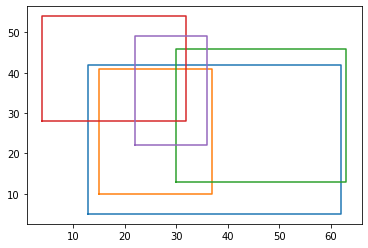

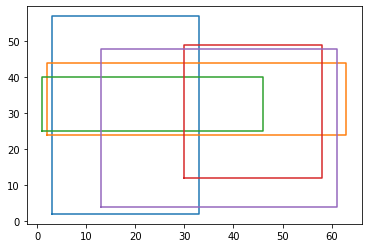

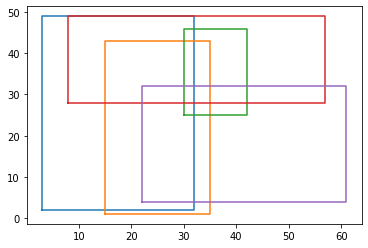

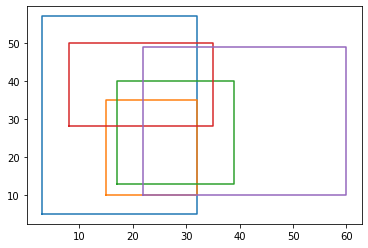

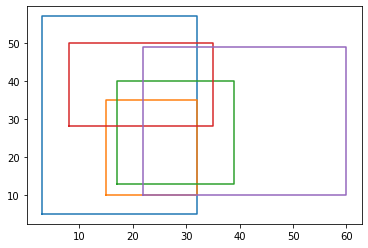

In [45]:
for model_id in range(5):
    for i in range(models.shape[1] // 4):
        top = models[model_id, 4 * i]
        bottom = models[model_id, 4 * i + 1]
        left = models[model_id, 4 * i + 2]
        right = models[model_id, 4 * i + 3]
        
        plt.plot(
            [left, right, right, left, left],
            [top, top, bottom, bottom, top]
        )
    plt.show()

### Greske

In [44]:
selected_features = model_from_vector(models[0])

X = create_feature_vector(selected_features, train_set)
X_test = create_feature_vector(selected_features, val_set)

M, S = estimate_normal(X)

accuracy, confusion_matrix = bayesian_inference(M, S, X_test)
    
print(end='\t')
for letter in labels:
    print(letter, end='\t')
print()    
for i, letter in enumerate(labels):
    print(letter, end='\t')
    for j in range(len(labels)):
        print(confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =", accuracy)

	A	E	I	O	U	
A	20.0	0.0	0.0	0.0	0.0	
E	0.0	18.0	0.0	0.0	2.0	
I	0.0	0.0	19.0	0.0	1.0	
O	0.0	0.0	0.0	20.0	0.0	
U	0.0	0.0	2.0	1.0	17.0	

accuracy = 0.94


### Koracna pretraga

In [46]:
def get_best_neighbour(model, evaluation_set, val_set):
    num_dims = len(model)
    line_search = 64
    diff = np.eye(num_dims)
    diff = np.concatenate([diff, -diff], axis=0).astype(int)
    diff = np.concatenate([i * diff for i in range(line_search)], axis=0).astype(int)
    diff = np.concatenate([diff, np.zeros((1, num_dims))], axis=0).astype(int)
    model = np.array([model])
    models = np.repeat(model, num_dims * line_search * 2, axis=0)
    models = np.concatenate([model, models], axis=0)
    models = models + diff
    return select_best_models(models, evaluation_set, k_fold=False, val_set=val_set)[0]

print(models[1])
model = models[1]
old_fitness = evaluate_model(model, train_set, k_fold=False, val_set=val_set)
print("First model fitnness:", old_fitness)

while True:
    new_model = get_best_neighbour(model, train_set, val_set)
    new_fitness = evaluate_model(new_model, train_set, k_fold=False, val_set=val_set)
    if new_fitness > old_fitness:
        old_fitness = new_fitness
        model = new_model
        print("New model fitnness:", new_fitness)
    else:
        break

print(model)
print(model - models[0])

final_accuracy = evaluate_model(model, train_set, k_fold=False, val_set=test_set)
print("Final accuracy:", final_accuracy)

[ 2 57  3 33 24 44  2 63 25 40  1 46 12 49 30 58  4 48 13 61]
First model fitnness: 0.87
New model fitnness: 0.95
New model fitnness: 0.98
New model fitnness: 0.99
[ 2 57  3 23 24 44  2 12 25 40  1 40 12 49 30 58  4 48 13 61]
[ -3  15 -10 -39  14   3 -13 -25  12  -6 -29 -23 -16  -5  26  26 -18  -1
  -9  25]
Final accuracy: 0.89
